# Fit logistic regression model

- based on different imputation methods
- baseline: reference
- model: any other selected imputation method

In [1]:
import logging
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import njab.sklearn
import pandas as pd
import sklearn
from njab.plotting.metrics import plot_split_auc, plot_split_prc
from njab.sklearn.types import Splits

import vaep
import vaep.analyzers
import vaep.io.datasplits

plt.rcParams['figure.figsize'] = (2.5, 2.5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.markersize'] = 2
fontsize = 5
figsize = (2.5, 2.5)
vaep.plotting.make_large_descriptors(fontsize)


logger = vaep.logging.setup_nb_logger()
logging.getLogger('fontTools').setLevel(logging.ERROR)


def parse_roc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _roc = (pd.DataFrame(_r.test.roc,
                             index='fpr tpr cutoffs'.split()
                             )).loc[['fpr', 'tpr']]
        _roc = _roc.T
        _roc.columns = pd.MultiIndex.from_product([[_r.name], _roc.columns])
        ret.append(_roc)
    ret = pd.concat(ret, axis=1)
    return ret


def parse_prc(*res: List[njab.sklearn.types.Results]) -> pd.DataFrame:
    ret = list()
    for _r in res:
        _prc = pd.DataFrame(_r.test.prc,
                            index='precision recall cutoffs'.split()
                            ).loc[['precision', 'recall']]
        _prc = _prc.T.rename(columns={'recall': 'tpr'})
        _prc.columns = pd.MultiIndex.from_product([[_r.name], _prc.columns])
        ret.append(_prc)
    ret = pd.concat(ret, axis=1)
    return ret


# catch passed parameters
args = None
args = dict(globals()).keys()

## Parameters
Default and set parameters for the notebook.

In [2]:
folder_data: str = ''  # specify data directory if needed
fn_clinical_data = "data/ALD_study/processed/ald_metadata_cli.csv"
folder_experiment = "runs/appl_ald_data/plasma/proteinGroups"
model_key = 'VAE'
target = 'kleiner'
sample_id_col = 'Sample ID'
cutoff_target: int = 2  # => for binarization target >= cutoff_target
file_format = "csv"
out_folder = 'diff_analysis'
fn_qc_samples = ''  # 'data/ALD_study/processed/qc_plasma_proteinGroups.pkl'

baseline = 'RSN'  # default is RSN, as this was used in the original ALD Niu. et. al 2022
template_pred = 'pred_real_na_{}.csv'  # fixed, do not change

In [3]:
# Parameters
cutoff_target = 0.5
folder_experiment = "runs/alzheimer_study"
target = "AD"
baseline = "PI"
model_key = "VAE"
out_folder = "diff_analysis"
fn_clinical_data = "runs/alzheimer_study/data/clinical_data.csv"


In [4]:
params = vaep.nb.get_params(args, globals=globals())
args = vaep.nb.Config()
args.folder_experiment = Path(params["folder_experiment"])
args = vaep.nb.add_default_paths(args,
                                 out_root=(args.folder_experiment
                                           / params["out_folder"]
                                           / params["target"]
                                           / f"{params['baseline']}_vs_{params['model_key']}"))
args.update_from_dict(params)
files_out = dict()
args

root - INFO     Removed from global namespace: folder_data


root - INFO     Removed from global namespace: fn_clinical_data


root - INFO     Removed from global namespace: folder_experiment


root - INFO     Removed from global namespace: model_key


root - INFO     Removed from global namespace: target


root - INFO     Removed from global namespace: sample_id_col


root - INFO     Removed from global namespace: cutoff_target


root - INFO     Removed from global namespace: file_format


root - INFO     Removed from global namespace: out_folder


root - INFO     Removed from global namespace: fn_qc_samples


root - INFO     Removed from global namespace: baseline


root - INFO     Removed from global namespace: template_pred


root - INFO     Already set attribute: folder_experiment has value runs/alzheimer_study


root - INFO     Already set attribute: out_folder has value diff_analysis


{'baseline': 'PI',
 'cutoff_target': 0.5,
 'data': PosixPath('runs/alzheimer_study/data'),
 'file_format': 'csv',
 'fn_clinical_data': 'runs/alzheimer_study/data/clinical_data.csv',
 'fn_qc_samples': '',
 'folder_data': '',
 'folder_experiment': PosixPath('runs/alzheimer_study'),
 'model_key': 'VAE',
 'out_figures': PosixPath('runs/alzheimer_study/figures'),
 'out_folder': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE'),
 'out_metrics': PosixPath('runs/alzheimer_study'),
 'out_models': PosixPath('runs/alzheimer_study'),
 'out_preds': PosixPath('runs/alzheimer_study/preds'),
 'sample_id_col': 'Sample ID',
 'target': 'AD',
 'template_pred': 'pred_real_na_{}.csv'}

## Load data

### Load target

In [5]:
target = pd.read_csv(args.fn_clinical_data,
                     index_col=0,
                     usecols=[args.sample_id_col, args.target])
target = target.dropna()
target

,AD
Sample ID,
Sample_000,0
Sample_001,1
Sample_002,1
Sample_003,1
Sample_004,1
...,...
Sample_205,1
Sample_206,0
Sample_207,0


### MS proteomics or specified omics data
Aggregated from data splits of the imputation workflow run before.

In [6]:
data = vaep.io.datasplits.DataSplits.from_folder(
    args.data, file_format=args.file_format)
data = pd.concat([data.train_X, data.val_y, data.test_y])
data.sample(5)

vaep.io.datasplits - INFO     Loaded 'train_X' from file: runs/alzheimer_study/data/train_X.csv


vaep.io.datasplits - INFO     Loaded 'val_y' from file: runs/alzheimer_study/data/val_y.csv


vaep.io.datasplits - INFO     Loaded 'test_y' from file: runs/alzheimer_study/data/test_y.csv


Sample ID   protein groups
Sample_151  Q9UBQ6           18.624
Sample_074  A0A1B0GXF2       20.557
Sample_186  H7C2F2           18.875
Sample_196  P05546           19.282
Sample_154  E7EQM8;P43146    17.043
Name: intensity, dtype: float64

Get overlap between independent features and target

### Select by ALD criteria
Use parameters as specified in [ALD study](https://github.com/RasmussenLab/pimms/tree/main/project/data/ALD_study).

In [7]:
DATA_COMPLETENESS = 0.6
MIN_N_PROTEIN_GROUPS: int = 200
FRAC_PROTEIN_GROUPS: int = 0.622
CV_QC_SAMPLE: float = 0.4

ald_study, cutoffs = vaep.analyzers.diff_analysis.select_raw_data(data.unstack(
), data_completeness=DATA_COMPLETENESS, frac_protein_groups=FRAC_PROTEIN_GROUPS)

if args.fn_qc_samples:
    qc_samples = pd.read_pickle(args.fn_qc_samples)
    qc_samples = qc_samples[ald_study.columns]
    qc_cv_feat = qc_samples.std() / qc_samples.mean()
    qc_cv_feat = qc_cv_feat.rename(qc_samples.columns.name)
    fig, ax = plt.subplots(figsize=(4, 7))
    ax = qc_cv_feat.plot.box(ax=ax)
    ax.set_ylabel('Coefficient of Variation')
    print((qc_cv_feat < CV_QC_SAMPLE).value_counts())
    ald_study = ald_study[vaep.analyzers.diff_analysis.select_feat(qc_samples)]

column_name_first_prot_to_pg = {
    pg.split(';')[0]: pg for pg in data.unstack().columns}

ald_study = ald_study.rename(columns=column_name_first_prot_to_pg)
ald_study

root - INFO     Initally: N samples: 210, M feat: 1421


root - INFO     Dropped features quantified in less than 126 samples.


root - INFO     After feat selection: N samples: 210, M feat: 1213


root - INFO     Min No. of Protein-Groups in single sample: 754


root - INFO     Finally: N samples: 210, M feat: 1213


protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,NaN,...,16.012,15.178,NaN,15.050,16.842,19.863,NaN,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,NaN,19.067,16.188,...,15.528,15.576,NaN,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,NaN,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,NaN,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,NaN,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,NaN,15.345,17.084,18.708,14.249,19.433,NaN,NaN
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Number of complete cases which can be used:

In [8]:
mask_has_target = data.index.levels[0].intersection(target.index)
assert not mask_has_target.empty, f"No data for target: {data.index.levels[0]} and {target.index}"
print(
    f"Samples available both in proteomics data and for target: {len(mask_has_target)}")
target, data, ald_study = target.loc[mask_has_target], data.loc[mask_has_target], ald_study.loc[mask_has_target]

Samples available both in proteomics data and for target: 210


### Load imputations from specified model

In [9]:
fname = args.out_preds / args.template_pred.format(args.model_key)
print(f"missing values pred. by {args.model_key}: {fname}")
load_single_csv_pred_file = vaep.analyzers.compare_predictions.load_single_csv_pred_file
pred_real_na = load_single_csv_pred_file(fname).loc[mask_has_target]
pred_real_na.sample(3)

missing values pred. by VAE: runs/alzheimer_study/preds/pred_real_na_VAE.csv


Sample ID   protein groups
Sample_153  J9JIG6;Q96EG1    14.700
Sample_078  P08582           13.307
Sample_025  O76061           15.758
Name: intensity, dtype: float64

### Load imputations from baseline model

In [10]:
fname = args.out_preds / args.template_pred.format(args.baseline)
pred_real_na_baseline = load_single_csv_pred_file(fname)  # .loc[mask_has_target]
pred_real_na_baseline

Sample ID   protein groups          
Sample_000  A0A075B6J9                 12.802
            A0A075B6Q5                 12.060
            A0A075B6R2                 13.757
            A0A075B6S5                 12.829
            A0A087WSY4                 13.755
                                        ...  
Sample_209  Q9P1W8;Q9P1W8-2;Q9P1W8-4   11.913
            Q9UI40;Q9UI40-2            12.941
            Q9UIW2                     13.120
            Q9UMX0;Q9UMX0-2;Q9UMX0-4   13.141
            Q9UP79                     13.073
Name: intensity, Length: 46401, dtype: float64

## Modeling setup
General approach:
  - use one train, test split of the data
  - select best 10 features from training data `X_train`, `y_train` before binarization of target
  - dichotomize (binarize) data into to groups (zero and 1)
  - evaluate model on the test data `X_test`, `y_test`

Repeat general approach for
 1. all original ald data: all features justed in original ALD study
 2. all model data: all features available my using the self supervised deep learning model
 3. newly available feat only: the subset of features available from the
    self supervised deep learning model which were newly retained using the
    new approach

All data:

In [11]:
X = pd.concat([data, pred_real_na]).unstack()
X

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H7,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,17.301,20.246,16.764,17.584,16.988,20.054,...,16.012,15.178,14.259,15.050,16.842,19.863,15.843,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,13.796,19.941,18.786,17.144,16.774,19.067,...,15.528,15.576,14.187,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,18.175,19.251,16.832,15.671,17.012,18.569,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,15.963,19.628,17.852,18.877,14.182,18.985,...,15.495,14.590,14.682,15.140,17.356,19.429,15.961,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,15.473,20.450,18.682,17.081,14.140,19.686,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,15.455,17.705,17.039,15.956,16.413,19.102,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,15.272,18.154,18.152,16.503,16.860,18.538,...,15.422,16.106,14.552,15.345,17.084,18.708,14.249,19.433,11.646,11.344
Sample_207,15.739,16.877,15.469,16.898,14.701,18.636,17.950,16.321,16.401,18.849,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


### Subset of data by ALD criteria

In [12]:
# could be just observed, drop columns with missing values
ald_study = pd.concat(
    [ald_study.stack(),
     pred_real_na_baseline.loc[
        # only select columns in selected in ald_study
        pd.IndexSlice[:, pred_real_na.index.levels[-1].intersection(ald_study.columns)]
    ]
    ]
).unstack()
ald_study

protein groups,A0A024QZX5;A0A087X1N8;P35237,A0A024R0T9;K7ER74;P02655,A0A024R3W6;A0A024R412;O60462;O60462-2;O60462-3;O60462-4;O60462-5;Q7LBX6;X5D2Q8,A0A024R644;A0A0A0MRU5;A0A1B0GWI2;O75503,A0A075B6H9,A0A075B6I0,A0A075B6I1,A0A075B6I6,A0A075B6I9,A0A075B6J9,...,Q9Y653;Q9Y653-2;Q9Y653-3,Q9Y696,Q9Y6C2,Q9Y6N6,Q9Y6N7;Q9Y6N7-2;Q9Y6N7-4,Q9Y6R7,Q9Y6X5,Q9Y6Y8;Q9Y6Y8-2,Q9Y6Y9,S4R3U6
Sample ID,,,,,,,,,,,,,,,,,,,,,
Sample_000,15.912,16.852,15.570,16.481,20.246,16.764,17.584,16.988,20.054,12.802,...,16.012,15.178,11.898,15.050,16.842,19.863,13.138,19.563,12.837,12.805
Sample_001,15.936,16.874,15.519,16.387,19.941,18.786,17.144,12.985,19.067,16.188,...,15.528,15.576,11.430,14.833,16.597,20.299,15.556,19.386,13.970,12.442
Sample_002,16.111,14.523,15.935,16.416,19.251,16.832,15.671,17.012,18.569,13.894,...,15.229,14.728,13.757,15.118,17.440,19.598,15.735,20.447,12.636,12.505
Sample_003,16.107,17.032,15.802,16.979,19.628,17.852,18.877,14.182,18.985,13.438,...,15.495,14.590,14.682,15.140,17.356,19.429,12.573,20.216,12.627,12.445
Sample_004,15.603,15.331,15.375,16.679,20.450,18.682,17.081,14.140,19.686,14.495,...,14.757,15.094,14.048,15.256,17.075,19.582,15.328,19.867,13.145,12.235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sample_205,15.682,16.886,14.910,16.482,17.705,17.039,11.445,16.413,19.102,16.064,...,15.235,15.684,14.236,15.415,17.551,17.922,16.340,19.928,12.929,11.802
Sample_206,15.798,17.554,15.600,15.938,18.154,18.152,16.503,16.860,18.538,15.288,...,15.422,16.106,12.912,15.345,17.084,18.708,14.249,19.433,12.696,12.159
Sample_207,15.739,16.877,15.469,16.898,18.636,17.950,16.321,16.401,18.849,17.580,...,15.808,16.098,14.403,15.715,16.586,18.725,16.138,19.599,13.637,11.174


Features which would not have been included using ALD criteria:

In [13]:
new_features = X.columns.difference(ald_study.columns)
new_features

Index(['A0A075B6H7', 'A0A075B6Q5', 'A0A075B7B8', 'A0A087WSY4',
       'A0A087WTT8;A0A0A0MQX5;O94779;O94779-2', 'A0A087WXB8;Q9Y274',
       'A0A087WXE9;E9PQ70;Q6UXH9;Q6UXH9-2;Q6UXH9-3',
       'A0A087X1Z2;C9JTV4;H0Y4Y4;Q8WYH2;Q96C19;Q9BUP0;Q9BUP0-2',
       'A0A0A0MQS9;A0A0A0MTC7;Q16363;Q16363-2', 'A0A0A0MSN4;P12821;P12821-2',
       ...
       'Q9NZ94;Q9NZ94-2;Q9NZ94-3', 'Q9NZU1', 'Q9P1W8;Q9P1W8-2;Q9P1W8-4',
       'Q9UHI8', 'Q9UI40;Q9UI40-2',
       'Q9UIB8;Q9UIB8-2;Q9UIB8-3;Q9UIB8-4;Q9UIB8-5;Q9UIB8-6',
       'Q9UKZ4;Q9UKZ4-2', 'Q9UMX0;Q9UMX0-2;Q9UMX0-4', 'Q9Y281;Q9Y281-3',
       'Q9Y490'],
      dtype='object', name='protein groups', length=208)

Binarize targets, but also keep groups for stratification

In [14]:
target_to_group = target.copy()
target = target >= args.cutoff_target
pd.crosstab(target.squeeze(), target_to_group.squeeze())

AD,0,1
AD,,
False,122,0
True,0,88


## Determine best number of parameters by cross validation procedure

using subset of data by ALD criteria:

In [15]:
cv_feat_ald = njab.sklearn.find_n_best_features(X=ald_study, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_ald = (cv_feat_ald
               .drop('test_case', axis=1)
               .groupby('n_features')
               .agg(['mean', 'std']))
cv_feat_ald

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 383.71it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  4.65it/s]

100%|██████████| 3/3 [00:00<00:00,  3.59it/s]

100%|██████████| 3/3 [00:00<00:00,  3.75it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  3.58it/s]

 75%|███████▌  | 3/4 [00:01<00:00,  2.86it/s]

100%|██████████| 4/4 [00:01<00:00,  2.93it/s]

100%|██████████| 4/4 [00:01<00:00,  2.99it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  3.64it/s]

 60%|██████    | 3/5 [00:01<00:00,  2.48it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.51it/s]

100%|██████████| 5/5 [00:01<00:00,  2.63it/s]

100%|██████████| 5/5 [00:01<00:00,  2.67it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:01,  3.24it/s]

 50%|█████     | 3/6 [00:01<00:01,  2.59it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.38it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.37it/s]

100%|██████████| 6/6 [00:02<00:00,  2.47it/s]

100%|██████████| 6/6 [00:02<00:00,  2.52it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.75it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.81it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.27it/s]

 71%|███████▏  | 5/7 [00:02<00:00,  2.24it/s]

 86%|████████▌ | 6/7 [00:02<00:00,  2.34it/s]

100%|██████████| 7/7 [00:02<00:00,  2.38it/s]

100%|██████████| 7/7 [00:02<00:00,  2.46it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  4.56it/s]

 38%|███▊      | 3/8 [00:00<00:01,  2.79it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.28it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  2.15it/s]

 75%|███████▌  | 6/8 [00:02<00:00,  2.17it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  2.14it/s]

100%|██████████| 8/8 [00:03<00:00,  2.31it/s]

100%|██████████| 8/8 [00:03<00:00,  2.37it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:02,  3.30it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.53it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.29it/s]

 56%|█████▌    | 5/9 [00:01<00:01,  2.48it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.51it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.53it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.52it/s]

100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:02,  3.77it/s]

 30%|███       | 3/10 [00:01<00:02,  2.65it/s]

 40%|████      | 4/10 [00:01<00:02,  2.25it/s]

 50%|█████     | 5/10 [00:02<00:02,  2.36it/s]

 60%|██████    | 6/10 [00:02<00:01,  2.53it/s]

 70%|███████   | 7/10 [00:02<00:01,  2.45it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.54it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.57it/s]

100%|██████████| 10/10 [00:03<00:00,  2.68it/s]

100%|██████████| 10/10 [00:03<00:00,  2.59it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:02,  3.14it/s]

 27%|██▋       | 3/11 [00:01<00:03,  2.30it/s]

 36%|███▋      | 4/11 [00:01<00:03,  1.93it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.76it/s]

 55%|█████▍    | 6/11 [00:03<00:02,  1.74it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.80it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.71it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.70it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.89it/s]

100%|██████████| 11/11 [00:05<00:00,  1.98it/s]

100%|██████████| 11/11 [00:05<00:00,  1.91it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:01,  5.54it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.05it/s]

 33%|███▎      | 4/12 [00:01<00:03,  2.45it/s]

 42%|████▏     | 5/12 [00:02<00:03,  2.16it/s]

 50%|█████     | 6/12 [00:02<00:02,  2.12it/s]

 58%|█████▊    | 7/12 [00:02<00:02,  2.10it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.21it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.33it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.47it/s]

 92%|█████████▏| 11/12 [00:04<00:00,  2.22it/s]

100%|██████████| 12/12 [00:05<00:00,  2.09it/s]

100%|██████████| 12/12 [00:05<00:00,  2.30it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:01,  6.27it/s]

 23%|██▎       | 3/13 [00:00<00:02,  3.73it/s]

 31%|███       | 4/13 [00:01<00:03,  2.60it/s]

 38%|███▊      | 5/13 [00:01<00:03,  2.09it/s]

 46%|████▌     | 6/13 [00:02<00:03,  1.75it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.78it/s]

 62%|██████▏   | 8/13 [00:03<00:02,  1.79it/s]

 69%|██████▉   | 9/13 [00:04<00:02,  1.87it/s]

 77%|███████▋  | 10/13 [00:04<00:01,  2.01it/s]

 85%|████████▍ | 11/13 [00:05<00:00,  2.22it/s]

 92%|█████████▏| 12/13 [00:05<00:00,  2.32it/s]

100%|██████████| 13/13 [00:05<00:00,  2.48it/s]

100%|██████████| 13/13 [00:05<00:00,  2.25it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  5.98it/s]

 21%|██▏       | 3/14 [00:00<00:02,  4.22it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.23it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.50it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.28it/s]

 50%|█████     | 7/14 [00:02<00:03,  2.13it/s]

 57%|█████▋    | 8/14 [00:03<00:02,  2.24it/s]

 64%|██████▍   | 9/14 [00:03<00:02,  2.33it/s]

 71%|███████▏  | 10/14 [00:03<00:01,  2.32it/s]

 79%|███████▊  | 11/14 [00:04<00:01,  2.25it/s]

 86%|████████▌ | 12/14 [00:04<00:00,  2.08it/s]

 93%|█████████▎| 13/14 [00:05<00:00,  2.02it/s]

100%|██████████| 14/14 [00:06<00:00,  1.92it/s]

100%|██████████| 14/14 [00:06<00:00,  2.30it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  5.09it/s]

 20%|██        | 3/15 [00:00<00:03,  3.80it/s]

 27%|██▋       | 4/15 [00:01<00:04,  2.56it/s]

 33%|███▎      | 5/15 [00:02<00:05,  1.99it/s]

 40%|████      | 6/15 [00:02<00:05,  1.79it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.72it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  1.82it/s]

 60%|██████    | 9/15 [00:04<00:02,  2.06it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  2.19it/s]

 73%|███████▎  | 11/15 [00:04<00:01,  2.27it/s]

 80%|████████  | 12/15 [00:05<00:01,  2.12it/s]

 87%|████████▋ | 13/15 [00:05<00:00,  2.34it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  2.39it/s]

100%|██████████| 15/15 [00:06<00:00,  2.47it/s]

100%|██████████| 15/15 [00:06<00:00,  2.26it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.004 0.002      0.050 0.014          0.617 0.426       0.087   
2             0.004 0.002      0.057 0.020          0.683 0.122       0.470   
3             0.005 0.003      0.054 0.018          0.687 0.114       0.523   
4             0.004 0.002      0.056 0.020          0.806 0.084       0.805   
5             0.005 0.003      0.051 0.013          0.803 0.080       0.811   
6             0.004 0.000      0.050 0.009          0.795 0.078       0.815   
7             0.004 0.002      0.050 0.011          0.800 0.086       0.794   
8             0.004 0.002      0.054 0.016          0.827 0.078       0.826   
9             0.005 0.003      0.058 0.022          0.825 0.077       0.823   
10            0.006 0.005      0.057 0.020          0.821 0.082       0.823   
11            0.005 0.005      0.068 0.031          0.838 0.083       0.831   
12            0.006 0.005      0.070 0.028          0.831 0.083       0.832   
13            0.007 0.007      0.084 0.036          0.829 0.082       0.826   
14            0.007 0.005      0.070 0.026          0.826 0.086       0.814   
15            0.008 0.006      0.077 0.026          0.823 0.088       0.812   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.082   0.147 0.128                  0.536 0.039        0.844   
2          0.121   0.547 0.103                  0.653 0.063        0.714   
3          0.131   0.584 0.103                  0.672 0.067        0.703   
4          0.100   0.801 0.071                  0.830 0.060        0.900   
5          0.108   0.803 0.073                  0.832 0.061        0.898   
6          0.113   0.800 0.073                  0.829 0.061        0.896   
7          0.107   0.792 0.073                  0.822 0.060        0.904   
8          0.097   0.823 0.071                  0.849 0.061        0.917   
9          0.096   0.821 0.069                  0.847 0.059        0.916   
10         0.096   0.819 0.071                  0.845 0.062        0.915   
11         0.095   0.831 0.070                  0.856 0.060        0.920   
12         0.090   0.828 0.068                  0.853 0.058        0.920   
13         0.091   0.824 0.063                  0.849 0.054        0.917   
14         0.099   0.815 0.068                  0.842 0.057        0.916   
15         0.098   0.813 0.068                  0.840 0.057        0.915   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.064                  0.816 0.086        210.000 0.000  
2          0.071                  0.656 0.075        210.000 0.000  
3          0.074                  0.651 0.084        210.000 0.000  
4          0.049                  0.876 0.059        210.000 0.000  
5          0.048                  0.873 0.058        210.000 0.000  
6          0.048                  0.870 0.058        210.000 0.000  
7          0.045                  0.887 0.052        210.000 0.000  
8          0.046                  0.911 0.045        210.000 0.000  
9          0.047                  0.910 0.045        210.000 0.000  
10         0.046                  0.908 0.045        210.000 0.000  
11         0.048                  0.911 0.048        210.000 0.000  
12         0.047                  0.909 0.047        210.000 0.000  
13         0.047                  0.908 0.047        210.000 0.000  
14         0.049                  0.908 0.047        210.000 0.000  
15         0.049                  0.906 0.047 

Using all data:

In [16]:
cv_feat_all = njab.sklearn.find_n_best_features(X=X, y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_all = cv_feat_all.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_all

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 443.51it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

100%|██████████| 2/2 [00:00<00:00,  3.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 67%|██████▋   | 2/3 [00:00<00:00,  5.57it/s]

100%|██████████| 3/3 [00:00<00:00,  3.58it/s]

100%|██████████| 3/3 [00:00<00:00,  3.81it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 50%|█████     | 2/4 [00:00<00:00,  5.41it/s]

 75%|███████▌  | 3/4 [00:00<00:00,  3.47it/s]

100%|██████████| 4/4 [00:01<00:00,  2.58it/s]

100%|██████████| 4/4 [00:01<00:00,  2.92it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:00<00:00,  4.80it/s]

 60%|██████    | 3/5 [00:00<00:00,  3.47it/s]

 80%|████████  | 4/5 [00:01<00:00,  2.44it/s]

100%|██████████| 5/5 [00:02<00:00,  2.11it/s]

100%|██████████| 5/5 [00:02<00:00,  2.47it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00,  5.34it/s]

 50%|█████     | 3/6 [00:00<00:00,  3.53it/s]

 67%|██████▋   | 4/6 [00:01<00:00,  2.36it/s]

 83%|████████▎ | 5/6 [00:02<00:00,  2.12it/s]

100%|██████████| 6/6 [00:02<00:00,  1.82it/s]

100%|██████████| 6/6 [00:02<00:00,  2.20it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 29%|██▊       | 2/7 [00:00<00:01,  3.24it/s]

 43%|████▎     | 3/7 [00:01<00:01,  2.31it/s]

 57%|█████▋    | 4/7 [00:01<00:01,  2.03it/s]

 71%|███████▏  | 5/7 [00:02<00:01,  1.87it/s]

 86%|████████▌ | 6/7 [00:03<00:00,  1.82it/s]

100%|██████████| 7/7 [00:03<00:00,  1.93it/s]

100%|██████████| 7/7 [00:03<00:00,  2.02it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 25%|██▌       | 2/8 [00:00<00:01,  5.06it/s]

 38%|███▊      | 3/8 [00:00<00:01,  3.97it/s]

 50%|█████     | 4/8 [00:01<00:01,  2.54it/s]

 62%|██████▎   | 5/8 [00:02<00:01,  1.96it/s]

 75%|███████▌  | 6/8 [00:02<00:01,  1.59it/s]

 88%|████████▊ | 7/8 [00:03<00:00,  1.52it/s]

100%|██████████| 8/8 [00:04<00:00,  1.68it/s]

100%|██████████| 8/8 [00:04<00:00,  1.94it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 22%|██▏       | 2/9 [00:00<00:01,  4.97it/s]

 33%|███▎      | 3/9 [00:01<00:02,  2.55it/s]

 44%|████▍     | 4/9 [00:01<00:02,  2.31it/s]

 56%|█████▌    | 5/9 [00:02<00:01,  2.21it/s]

 67%|██████▋   | 6/9 [00:02<00:01,  2.22it/s]

 78%|███████▊  | 7/9 [00:02<00:00,  2.25it/s]

 89%|████████▉ | 8/9 [00:03<00:00,  2.17it/s]

100%|██████████| 9/9 [00:04<00:00,  1.99it/s]

100%|██████████| 9/9 [00:04<00:00,  2.23it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 20%|██        | 2/10 [00:00<00:01,  4.41it/s]

 30%|███       | 3/10 [00:00<00:02,  3.16it/s]

 40%|████      | 4/10 [00:01<00:02,  2.86it/s]

 50%|█████     | 5/10 [00:01<00:02,  2.18it/s]

 60%|██████    | 6/10 [00:02<00:02,  1.95it/s]

 70%|███████   | 7/10 [00:03<00:01,  1.95it/s]

 80%|████████  | 8/10 [00:03<00:00,  2.07it/s]

 90%|█████████ | 9/10 [00:03<00:00,  2.19it/s]

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

100%|██████████| 10/10 [00:04<00:00,  2.33it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  5.34it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.80it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.72it/s]

 45%|████▌     | 5/11 [00:02<00:03,  1.93it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  1.69it/s]

 64%|██████▎   | 7/11 [00:03<00:02,  1.55it/s]

 73%|███████▎  | 8/11 [00:04<00:01,  1.53it/s]

 82%|████████▏ | 9/11 [00:04<00:01,  1.61it/s]

 91%|█████████ | 10/11 [00:05<00:00,  1.77it/s]

100%|██████████| 11/11 [00:05<00:00,  1.87it/s]

100%|██████████| 11/11 [00:05<00:00,  1.92it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:02,  4.87it/s]

 25%|██▌       | 3/12 [00:00<00:02,  3.45it/s]

 33%|███▎      | 4/12 [00:01<00:02,  2.73it/s]

 42%|████▏     | 5/12 [00:01<00:03,  2.30it/s]

 50%|█████     | 6/12 [00:02<00:03,  1.97it/s]

 58%|█████▊    | 7/12 [00:03<00:02,  1.88it/s]

 67%|██████▋   | 8/12 [00:03<00:01,  2.02it/s]

 75%|███████▌  | 9/12 [00:03<00:01,  2.08it/s]

 83%|████████▎ | 10/12 [00:04<00:00,  2.02it/s]

 92%|█████████▏| 11/12 [00:05<00:00,  1.88it/s]

100%|██████████| 12/12 [00:05<00:00,  1.87it/s]

100%|██████████| 12/12 [00:05<00:00,  2.12it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:03,  2.84it/s]

 23%|██▎       | 3/13 [00:01<00:04,  2.14it/s]

 31%|███       | 4/13 [00:01<00:04,  1.92it/s]

 38%|███▊      | 5/13 [00:02<00:04,  1.89it/s]

 46%|████▌     | 6/13 [00:03<00:04,  1.67it/s]

 54%|█████▍    | 7/13 [00:03<00:03,  1.61it/s]

 62%|██████▏   | 8/13 [00:04<00:03,  1.59it/s]

 69%|██████▉   | 9/13 [00:05<00:02,  1.58it/s]

 77%|███████▋  | 10/13 [00:05<00:01,  1.72it/s]

 85%|████████▍ | 11/13 [00:06<00:01,  1.87it/s]

 92%|█████████▏| 12/13 [00:06<00:00,  1.99it/s]

100%|██████████| 13/13 [00:06<00:00,  2.09it/s]

100%|██████████| 13/13 [00:06<00:00,  1.88it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:02,  4.42it/s]

 21%|██▏       | 3/14 [00:00<00:03,  3.13it/s]

 29%|██▊       | 4/14 [00:01<00:03,  3.03it/s]

 36%|███▌      | 5/14 [00:01<00:03,  2.53it/s]

 43%|████▎     | 6/14 [00:02<00:03,  2.21it/s]

 50%|█████     | 7/14 [00:03<00:03,  1.89it/s]

 57%|█████▋    | 8/14 [00:03<00:03,  1.80it/s]

 64%|██████▍   | 9/14 [00:04<00:02,  1.95it/s]

 71%|███████▏  | 10/14 [00:04<00:01,  2.02it/s]

 79%|███████▊  | 11/14 [00:05<00:01,  1.91it/s]

 86%|████████▌ | 12/14 [00:05<00:01,  1.76it/s]

 93%|█████████▎| 13/14 [00:06<00:00,  1.75it/s]

100%|██████████| 14/14 [00:06<00:00,  1.73it/s]

100%|██████████| 14/14 [00:06<00:00,  2.02it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.81it/s]

 20%|██        | 3/15 [00:00<00:03,  3.38it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.92it/s]

 33%|███▎      | 5/15 [00:01<00:04,  2.28it/s]

 40%|████      | 6/15 [00:02<00:04,  1.99it/s]

 47%|████▋     | 7/15 [00:03<00:04,  1.70it/s]

 53%|█████▎    | 8/15 [00:04<00:04,  1.54it/s]

 60%|██████    | 9/15 [00:04<00:04,  1.46it/s]

 67%|██████▋   | 10/15 [00:05<00:03,  1.51it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.64it/s]

 80%|████████  | 12/15 [00:06<00:01,  1.80it/s]

 87%|████████▋ | 13/15 [00:06<00:01,  1.91it/s]

 93%|█████████▎| 14/15 [00:07<00:00,  1.98it/s]

100%|██████████| 15/15 [00:07<00:00,  2.02it/s]

100%|██████████| 15/15 [00:07<00:00,  1.94it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.007 0.006      0.085 0.031          0.010 0.071       0.001   
2             0.007 0.008      0.088 0.041          0.773 0.119       0.634   
3             0.009 0.008      0.108 0.037          0.757 0.091       0.673   
4             0.007 0.006      0.090 0.041          0.754 0.094       0.671   
5             0.007 0.005      0.086 0.029          0.747 0.100       0.660   
6             0.006 0.004      0.073 0.027          0.742 0.096       0.673   
7             0.006 0.005      0.077 0.035          0.752 0.103       0.691   
8             0.007 0.005      0.084 0.032          0.753 0.102       0.697   
9             0.007 0.006      0.082 0.036          0.764 0.095       0.743   
10            0.007 0.006      0.090 0.043          0.776 0.094       0.760   
11            0.007 0.005      0.087 0.032          0.793 0.086       0.797   
12            0.007 0.006      0.070 0.024          0.786 0.092       0.796   
13            0.007 0.006      0.091 0.044          0.789 0.091       0.795   
14            0.005 0.003      0.077 0.037          0.786 0.089       0.799   
15            0.005 0.003      0.058 0.021          0.789 0.087       0.784   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.008   0.002 0.015                  0.497 0.008        0.859   
2          0.125   0.688 0.096                  0.745 0.073        0.790   
3          0.121   0.706 0.088                  0.756 0.066        0.853   
4          0.119   0.704 0.088                  0.754 0.067        0.851   
5          0.132   0.693 0.093                  0.746 0.071        0.867   
6          0.130   0.699 0.094                  0.750 0.073        0.867   
7          0.132   0.715 0.101                  0.762 0.081        0.874   
8          0.131   0.718 0.099                  0.764 0.078        0.871   
9          0.125   0.749 0.095                  0.787 0.079        0.884   
10         0.125   0.764 0.097                  0.799 0.081        0.889   
11         0.112   0.791 0.081                  0.822 0.068        0.913   
12         0.112   0.787 0.083                  0.817 0.071        0.915   
13         0.112   0.787 0.082                  0.818 0.070        0.914   
14         0.109   0.788 0.079                  0.818 0.068        0.912   
15         0.110   0.782 0.080                  0.814 0.068        0.917   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.063                  0.827 0.088        210.000 0.000  
2          0.076                  0.734 0.095        210.000 0.000  
3          0.060                  0.820 0.073        210.000 0.000  
4          0.061                  0.819 0.072        210.000 0.000  
5          0.057                  0.837 0.068        210.000 0.000  
6          0.056                  0.839 0.065        210.000 0.000  
7          0.060                  0.846 0.069        210.000 0.000  
8          0.061                  0.842 0.070        210.000 0.000  
9          0.058                  0.865 0.065        210.000 0.000  
10         0.056                  0.864 0.066        210.000 0.000  
11         0.047                  0.891 0.055        210.000 0.000  
12         0.047                  0.895 0.055        210.000 0.000  
13         0.047                  0.893 0.055        210.000 0.000  
14         0.048                  0.889 0.056        210.000 0.000  
15         0.046                  0.895 0.055 

Using only new features:

In [17]:
cv_feat_new = njab.sklearn.find_n_best_features(X=X.loc[:, new_features],
                                                y=target, name=args.target,
                                                groups=target_to_group)
cv_feat_new = cv_feat_new.drop('test_case', axis=1).groupby('n_features').agg(['mean', 'std'])
cv_feat_new

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 980.21it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 25.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:00<00:00, 16.25it/s]

100%|██████████| 3/3 [00:00<00:00, 16.11it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

 75%|███████▌  | 3/4 [00:00<00:00, 15.61it/s]

100%|██████████| 4/4 [00:00<00:00, 12.94it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 19.13it/s]

100%|██████████| 5/5 [00:00<00:00, 12.53it/s]

100%|██████████| 5/5 [00:00<00:00, 12.77it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

 33%|███▎      | 2/6 [00:00<00:00, 16.68it/s]

 67%|██████▋   | 4/6 [00:00<00:00, 11.96it/s]

100%|██████████| 6/6 [00:00<00:00, 12.07it/s]

100%|██████████| 6/6 [00:00<00:00, 12.32it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

 43%|████▎     | 3/7 [00:00<00:00, 17.54it/s]

 71%|███████▏  | 5/7 [00:00<00:00, 14.28it/s]

100%|██████████| 7/7 [00:00<00:00, 13.82it/s]

100%|██████████| 7/7 [00:00<00:00, 14.21it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

 38%|███▊      | 3/8 [00:00<00:00, 17.22it/s]

 62%|██████▎   | 5/8 [00:00<00:00, 11.76it/s]

 88%|████████▊ | 7/8 [00:00<00:00, 10.55it/s]

100%|██████████| 8/8 [00:00<00:00, 10.86it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

 33%|███▎      | 3/9 [00:00<00:00, 15.52it/s]

 56%|█████▌    | 5/9 [00:00<00:00, 14.04it/s]

 78%|███████▊  | 7/9 [00:00<00:00, 12.99it/s]

100%|██████████| 9/9 [00:00<00:00, 12.37it/s]

100%|██████████| 9/9 [00:00<00:00, 12.91it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

 30%|███       | 3/10 [00:00<00:00, 21.19it/s]

 60%|██████    | 6/10 [00:00<00:00, 12.40it/s]

 80%|████████  | 8/10 [00:00<00:00, 10.92it/s]

100%|██████████| 10/10 [00:00<00:00, 11.26it/s]

100%|██████████| 10/10 [00:00<00:00, 11.83it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [00:00<00:00, 19.34it/s]

 45%|████▌     | 5/11 [00:00<00:00, 15.70it/s]

 64%|██████▎   | 7/11 [00:00<00:00, 13.64it/s]

 82%|████████▏ | 9/11 [00:00<00:00, 12.72it/s]

100%|██████████| 11/11 [00:00<00:00, 12.00it/s]

100%|██████████| 11/11 [00:00<00:00, 13.03it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

 17%|█▋        | 2/12 [00:00<00:00, 19.80it/s]

 33%|███▎      | 4/12 [00:00<00:00, 12.55it/s]

 50%|█████     | 6/12 [00:00<00:00, 11.25it/s]

 67%|██████▋   | 8/12 [00:00<00:00, 10.41it/s]

 83%|████████▎ | 10/12 [00:00<00:00, 10.78it/s]

100%|██████████| 12/12 [00:01<00:00,  9.99it/s]

100%|██████████| 12/12 [00:01<00:00, 10.72it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 23%|██▎       | 3/13 [00:00<00:00, 15.58it/s]

 38%|███▊      | 5/13 [00:00<00:00, 12.38it/s]

 54%|█████▍    | 7/13 [00:00<00:00, 10.77it/s]

 69%|██████▉   | 9/13 [00:00<00:00, 11.86it/s]

 85%|████████▍ | 11/13 [00:00<00:00, 11.71it/s]

100%|██████████| 13/13 [00:01<00:00, 11.63it/s]

100%|██████████| 13/13 [00:01<00:00, 11.81it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

 14%|█▍        | 2/14 [00:00<00:00, 15.37it/s]

 29%|██▊       | 4/14 [00:00<00:01,  9.50it/s]

 43%|████▎     | 6/14 [00:00<00:00,  9.07it/s]

 50%|█████     | 7/14 [00:00<00:00,  8.72it/s]

 64%|██████▍   | 9/14 [00:00<00:00,  9.01it/s]

 79%|███████▊  | 11/14 [00:01<00:00,  9.16it/s]

 86%|████████▌ | 12/14 [00:01<00:00,  9.31it/s]

 93%|█████████▎| 13/14 [00:01<00:00,  9.25it/s]

100%|██████████| 14/14 [00:01<00:00,  8.97it/s]

100%|██████████| 14/14 [00:01<00:00,  9.17it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:00, 13.86it/s]

 27%|██▋       | 4/15 [00:00<00:00, 13.79it/s]

 40%|████      | 6/15 [00:00<00:00, 12.07it/s]

 53%|█████▎    | 8/15 [00:00<00:00, 11.63it/s]

 67%|██████▋   | 10/15 [00:00<00:00, 10.68it/s]

 80%|████████  | 12/15 [00:01<00:00, 10.59it/s]

 93%|█████████▎| 14/15 [00:01<00:00, 10.17it/s]

100%|██████████| 15/15 [00:01<00:00, 10.89it/s]

fit_time       score_time       test_precision       test_recall  \
               mean   std       mean   std           mean   std        mean   
n_features                                                                    
1             0.006 0.005      0.069 0.026          0.000 0.000       0.000   
2             0.004 0.002      0.050 0.012          0.681 0.099       0.586   
3             0.004 0.003      0.064 0.022          0.687 0.092       0.571   
4             0.004 0.002      0.055 0.016          0.669 0.088       0.579   
5             0.006 0.007      0.065 0.024          0.657 0.095       0.579   
6             0.004 0.003      0.059 0.019          0.645 0.104       0.568   
7             0.006 0.004      0.064 0.023          0.645 0.105       0.561   
8             0.005 0.004      0.059 0.022          0.632 0.099       0.556   
9             0.006 0.004      0.069 0.030          0.654 0.097       0.570   
10            0.005 0.004      0.062 0.020          0.671 0.093       0.626   
11            0.005 0.004      0.059 0.024          0.673 0.095       0.647   
12            0.005 0.004      0.060 0.019          0.667 0.088       0.639   
13            0.004 0.002      0.051 0.013          0.682 0.095       0.654   
14            0.007 0.007      0.063 0.022          0.676 0.089       0.649   
15            0.005 0.004      0.055 0.013          0.685 0.096       0.650   

                 test_f1       test_balanced_accuracy       test_roc_auc  \
             std    mean   std                   mean   std         mean   
n_features                                                                 
1          0.000   0.000 0.000                  0.500 0.000        0.722   
2          0.121   0.622 0.095                  0.690 0.071        0.784   
3          0.112   0.617 0.083                  0.689 0.061        0.785   
4          0.118   0.613 0.085                  0.683 0.063        0.777   
5          0.113   0.608 0.083                  0.676 0.065        0.771   
6          0.111   0.597 0.087                  0.666 0.069        0.765   
7          0.112   0.593 0.088                  0.664 0.069        0.762   
8          0.128   0.583 0.094                  0.658 0.069        0.760   
9          0.119   0.600 0.082                  0.670 0.063        0.755   
10         0.108   0.643 0.083                  0.699 0.066        0.790   
11         0.115   0.654 0.088                  0.707 0.071        0.790   
12         0.107   0.647 0.079                  0.701 0.063        0.792   
13         0.113   0.662 0.085                  0.713 0.068        0.793   
14         0.109   0.657 0.082                  0.709 0.064        0.791   
15         0.111   0.662 0.085                  0.714 0.067        0.792   

                 test_average_precision       n_observations        
             std                   mean   std           mean   std  
n_features                                                          
1          0.067                  0.686 0.072        210.000 0.000  
2          0.072                  0.734 0.080        210.000 0.000  
3          0.069                  0.740 0.076        210.000 0.000  
4          0.069                  0.731 0.072        210.000 0.000  
5          0.069                  0.724 0.075        210.000 0.000  
6          0.068                  0.715 0.074        210.000 0.000  
7          0.068                  0.712 0.077        210.000 0.000  
8          0.069                  0.711 0.076        210.000 0.000  
9          0.067                  0.712 0.072        210.000 0.000  
10         0.068                  0.748 0.081        210.000 0.000  
11         0.067                  0.757 0.080        210.000 0.000  
12         0.066                  0.758 0.080        210.000 0.000  
13         0.064                  0.758 0.077        210.000 0.000  
14         0.064                  0.755 0.078        210.000 0.000  
15         0.066                  0.752 0.081 

### Best number of features by subset of the data:

In [18]:
n_feat_best = pd.DataFrame(
    {'ald': cv_feat_ald.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'all': cv_feat_all.loc[:, pd.IndexSlice[:, 'mean']].idxmax(),
     'new': cv_feat_new.loc[:, pd.IndexSlice[:, 'mean']].idxmax()
     }
).droplevel(-1)
n_feat_best

,ald,all,new
fit_time,15,3,14
score_time,13,3,9
test_precision,11,11,3
test_recall,12,14,13
test_f1,11,11,15
test_balanced_accuracy,11,11,15
test_roc_auc,11,15,13
test_average_precision,11,15,13
n_observations,1,1,1


## Train, test split
Show number of cases in train and test data

In [19]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    target,
    test_size=.2,
    stratify=target_to_group,
    random_state=42)
idx_train = X_train.index
idx_test = X_test.index

njab.pandas.combine_value_counts(
    pd.concat([y_train, y_test],
              axis=1,
              ignore_index=True,
              ).rename(columns={0: 'train', 1: 'test'})
)

,train,test
False,98,24
True,70,18


## Results

- `run_model` returns dataclasses with the further needed results
- add mrmr selection of data (select best number of features to use instead of fixing it)

Save results for final model on entire data, new features and ALD study criteria selected data.

In [20]:
splits = Splits(X_train=X.loc[idx_train],
                X_test=X.loc[idx_test],
                y_train=y_train,
                y_test=y_test)
results_model_full = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'all'])
results_model_full.name = f'{args.model_key} all'
fname = args.out_folder / f'results_{results_model_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_full, fname)

splits = Splits(X_train=X.loc[idx_train, new_features],
                X_test=X.loc[idx_test, new_features],
                y_train=y_train,
                y_test=y_test)
results_model_new = njab.sklearn.run_model(
    splits,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'new'])
results_model_new.name = f'{args.model_key} new'
fname = args.out_folder / f'results_{results_model_new.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_model_new, fname)

splits_ald = Splits(
    X_train=ald_study.loc[idx_train],
    X_test=ald_study.loc[idx_test],
    y_train=y_train,
    y_test=y_test)
results_ald_full = njab.sklearn.run_model(
    splits_ald,
    n_feat_to_select=n_feat_best.loc['test_roc_auc', 'ald'])
results_ald_full.name = 'ALD study all'
fname = args.out_folder / f'results_{results_ald_full.name}.pkl'
files_out[fname.name] = fname
vaep.io.to_pickle(results_ald_full, fname)

  0%|          | 0/15 [00:00<?, ?it/s]

 13%|█▎        | 2/15 [00:00<00:02,  4.81it/s]

 20%|██        | 3/15 [00:00<00:03,  3.39it/s]

 27%|██▋       | 4/15 [00:01<00:03,  2.92it/s]

 33%|███▎      | 5/15 [00:01<00:03,  2.74it/s]

 40%|████      | 6/15 [00:02<00:03,  2.67it/s]

 47%|████▋     | 7/15 [00:02<00:03,  2.27it/s]

 53%|█████▎    | 8/15 [00:03<00:03,  2.04it/s]

 60%|██████    | 9/15 [00:03<00:03,  1.90it/s]

 67%|██████▋   | 10/15 [00:04<00:02,  1.82it/s]

 73%|███████▎  | 11/15 [00:05<00:02,  1.78it/s]

 80%|████████  | 12/15 [00:05<00:01,  1.88it/s]

 87%|████████▋ | 13/15 [00:05<00:01,  1.98it/s]

 93%|█████████▎| 14/15 [00:06<00:00,  1.95it/s]

100%|██████████| 15/15 [00:06<00:00,  2.04it/s]

100%|██████████| 15/15 [00:06<00:00,  2.17it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

 15%|█▌        | 2/13 [00:00<00:00, 14.04it/s]

 31%|███       | 4/13 [00:00<00:00,  9.12it/s]

 46%|████▌     | 6/13 [00:00<00:00,  7.96it/s]

 54%|█████▍    | 7/13 [00:00<00:00,  7.89it/s]

 62%|██████▏   | 8/13 [00:00<00:00,  7.55it/s]

 69%|██████▉   | 9/13 [00:01<00:00,  7.84it/s]

 77%|███████▋  | 10/13 [00:01<00:00,  8.28it/s]

 92%|█████████▏| 12/13 [00:01<00:00,  8.80it/s]

100%|██████████| 13/13 [00:01<00:00,  9.05it/s]

100%|██████████| 13/13 [00:01<00:00,  8.56it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [00:00<00:01,  4.64it/s]

 27%|██▋       | 3/11 [00:00<00:02,  3.33it/s]

 36%|███▋      | 4/11 [00:01<00:02,  2.82it/s]

 45%|████▌     | 5/11 [00:01<00:02,  2.57it/s]

 55%|█████▍    | 6/11 [00:02<00:02,  2.48it/s]

 64%|██████▎   | 7/11 [00:02<00:01,  2.34it/s]

 73%|███████▎  | 8/11 [00:03<00:01,  2.37it/s]

 82%|████████▏ | 9/11 [00:03<00:00,  2.66it/s]

 91%|█████████ | 10/11 [00:03<00:00,  2.81it/s]

100%|██████████| 11/11 [00:04<00:00,  2.62it/s]

100%|██████████| 11/11 [00:04<00:00,  2.69it/s]

### ROC-AUC on test split

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf


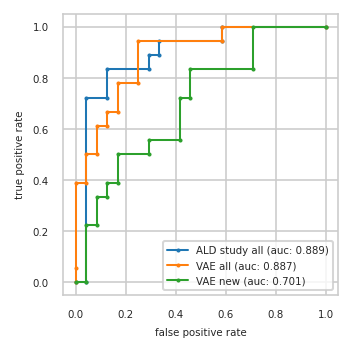

In [21]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.test, results_ald_full.name, ax)
plot_split_auc(results_model_full.test, results_model_full.name, ax)
plot_split_auc(results_model_new.test, results_model_new.name, ax)
fname = args.out_folder / 'auc_roc_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot ROC:

In [22]:
res = [results_ald_full, results_model_full, results_model_new]

auc_roc_curve = parse_roc(*res)
auc_roc_curve.to_excel(fname.with_suffix('.xlsx'))
auc_roc_curve

ALD study all       VAE all       VAE new      
             fpr   tpr     fpr   tpr     fpr   tpr
0          0.000 0.000   0.000 0.000   0.000 0.000
1          0.042 0.000   0.000 0.056   0.042 0.000
2          0.042 0.722   0.000 0.389   0.042 0.222
3          0.125 0.722   0.042 0.389   0.083 0.222
4          0.125 0.833   0.042 0.500   0.083 0.333
5          0.292 0.833   0.083 0.500   0.125 0.333
6          0.292 0.889   0.083 0.611   0.125 0.389
7          0.333 0.889   0.125 0.611   0.167 0.389
8          0.333 0.944   0.125 0.667   0.167 0.500
9          0.583 0.944   0.167 0.667   0.292 0.500
10         0.583 1.000   0.167 0.778   0.292 0.556
11         1.000 1.000   0.250 0.778   0.417 0.556
12           NaN   NaN   0.250 0.944   0.417 0.722
13           NaN   NaN   0.583 0.944   0.458 0.722
14           NaN   NaN   0.583 1.000   0.458 0.833
15           NaN   NaN   1.000 1.000   0.708 0.833
16           NaN   NaN     NaN   NaN   0.708 1.000
17           NaN   NaN     NaN   NaN   1.000 1.000

### Features selected for final models

In [23]:
selected_features = pd.DataFrame(
    [results_ald_full.selected_features,
     results_model_full.selected_features,
     results_model_new.selected_features],
    index=[
        results_ald_full.name,
        results_model_full.name,
        results_model_new.name]
).T
selected_features.index.name = 'rank'
fname = args.out_folder / 'mrmr_feat_by_model.xlsx'
files_out[fname.name] = fname
selected_features.to_excel(fname)
selected_features

,ALD study all,VAE all,VAE new
rank,,,
0,P04075,P10636-2;P10636-6,Q14894
1,Q9NRN5,K7ER15;Q9H0R4;Q9H0R4-2,P51688
2,P09486,P02741,J3KSJ8;Q9UD71;Q9UD71-2
3,K7ERG9;P00746,P61981,Q96GD0
4,P14174,Q9Y2T3;Q9Y2T3-3,A0A0C4DGV4;E9PLX3;O43504;R4GMU8
5,P10636-2;P10636-6,P04075,P31321
6,P61981,P14174,Q9NUQ9
7,Q6EMK4,Q14894,F8WBF9;Q5TH30;Q9UGV2;Q9UGV2-2;Q9UGV2-3
8,Q9Y2T3;Q9Y2T3-3,P63104,E9PK25;G3V1A4;P23528


### Precision-Recall plot on test data

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf


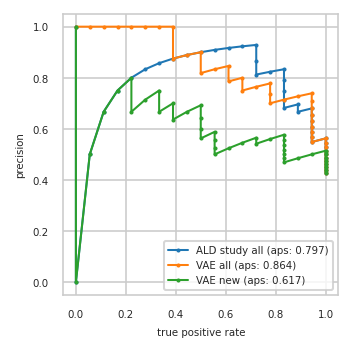

In [24]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.test, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.test, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.test, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Data used to plot PRC:

In [25]:
prec_recall_curve = parse_prc(*res)
prec_recall_curve.to_excel(fname.with_suffix('.xlsx'))
prec_recall_curve

ALD study all         VAE all         VAE new      
       precision   tpr precision   tpr precision   tpr
0          0.429 1.000     0.429 1.000     0.429 1.000
1          0.439 1.000     0.439 1.000     0.439 1.000
2          0.450 1.000     0.450 1.000     0.450 1.000
3          0.462 1.000     0.462 1.000     0.462 1.000
4          0.474 1.000     0.474 1.000     0.474 1.000
5          0.486 1.000     0.486 1.000     0.486 1.000
6          0.500 1.000     0.500 1.000     0.500 1.000
7          0.514 1.000     0.514 1.000     0.514 1.000
8          0.529 1.000     0.529 1.000     0.500 0.944
9          0.545 1.000     0.545 1.000     0.485 0.889
10         0.562 1.000     0.562 1.000     0.469 0.833
11         0.548 0.944     0.548 0.944     0.484 0.833
12         0.567 0.944     0.567 0.944     0.500 0.833
13         0.586 0.944     0.586 0.944     0.517 0.833
14         0.607 0.944     0.607 0.944     0.536 0.833
15         0.630 0.944     0.630 0.944     0.556 0.833
16         0.654 0.944     0.654 0.944     0.577 0.833
17         0.680 0.944     0.680 0.944     0.560 0.778
18         0.667 0.889     0.708 0.944     0.542 0.722
19         0.696 0.889     0.739 0.944     0.565 0.722
20         0.682 0.833     0.727 0.889     0.545 0.667
21         0.714 0.833     0.714 0.833     0.524 0.611
22         0.750 0.833     0.700 0.778     0.500 0.556
23         0.789 0.833     0.737 0.778     0.526 0.556
24         0.833 0.833     0.778 0.778     0.556 0.556
25         0.824 0.778     0.765 0.722     0.588 0.556
26         0.812 0.722     0.750 0.667     0.562 0.500
27         0.867 0.722     0.800 0.667     0.600 0.500
28         0.929 0.722     0.786 0.611     0.643 0.500
29         0.923 0.667     0.846 0.611     0.692 0.500
30         0.917 0.611     0.833 0.556     0.667 0.444
31         0.909 0.556     0.818 0.500     0.636 0.389
32         0.900 0.500     0.900 0.500     0.700 0.389
33         0.889 0.444     0.889 0.444     0.667 0.333
34         0.875 0.389     0.875 0.389     0.750 0.333
35         0.857 0.333     1.000 0.389     0.714 0.278
36         0.833 0.278     1.000 0.333     0.667 0.222
37         0.800 0.222     1.000 0.278     0.800 0.222
38         0.750 0.167     1.000 0.222     0.750 0.167
39         0.667 0.111     1.000 0.167     0.667 0.111
40         0.500 0.056     1.000 0.111     0.500 0.056
41         0.000 0.000     1.000 0.056     0.000 0.000
42         1.000 0.000     1.000 0.000     1.000 0.000

## Train data plots

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf


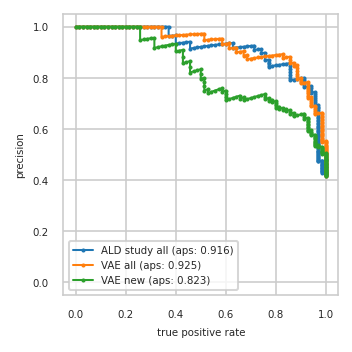

In [26]:
fig, ax = plt.subplots(1, 1, figsize=figsize)

ax = plot_split_prc(results_ald_full.train, results_ald_full.name, ax)
ax = plot_split_prc(results_model_full.train, results_model_full.name, ax)
ax = plot_split_prc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'prec_recall_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

vaep.plotting - INFO     Saved Figures to runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf


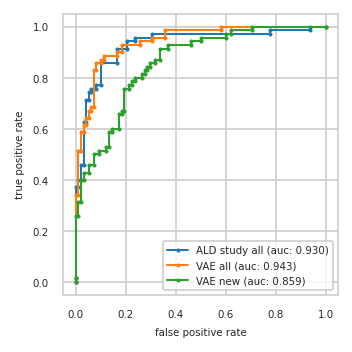

In [27]:
fig, ax = plt.subplots(1, 1, figsize=figsize)
plot_split_auc(results_ald_full.train, results_ald_full.name, ax)
plot_split_auc(results_model_full.train, results_model_full.name, ax)
plot_split_auc(results_model_new.train, results_model_new.name, ax)
fname = folder = args.out_folder / 'auc_roc_curve_train.pdf'
files_out[fname.name] = fname
vaep.savefig(fig, name=fname)

Output files:

In [28]:
files_out

{'results_VAE all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE all.pkl'),
 'results_VAE new.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_VAE new.pkl'),
 'results_ALD study all.pkl': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/results_ALD study all.pkl'),
 'auc_roc_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve.pdf'),
 'mrmr_feat_by_model.xlsx': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/mrmr_feat_by_model.xlsx'),
 'prec_recall_curve.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve.pdf'),
 'prec_recall_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/prec_recall_curve_train.pdf'),
 'auc_roc_curve_train.pdf': PosixPath('runs/alzheimer_study/diff_analysis/AD/PI_vs_VAE/auc_roc_curve_train.pdf')}